<h1 style="text-align: center">
Deep Learning HW2 </br> 
Image Segmentation with U-Net
</h1>

## Name: Arya Jalali

## Std. Number: 98105665

You'll be building your own U-Net, a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset. 

This type of image classification is called semantic image segmentation. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class. The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<img src="/content/images/carseg.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

As you might imagine, region-specific labeling is a pretty crucial consideration for self-driving cars, which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars, or any number of traffic obstacles that can put peoples' lives in danger. 

By the time you finish this notebook, you'll be able to: 

* Build your own U-Net
* Explain the difference between a regular CNN and a U-net
* Implement semantic image segmentation on the CARLA self-driving car dataset
* Apply sparse categorical crossentropy for pixelwise prediction

Onward, to this grand and glorious quest!

## Downloading Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install torch-summary
!gdown --id 11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3
To: /content/Files.zip
100% 545M/545M [00:02<00:00, 186MB/s]


In [2]:
!unzip Files.zip

Archive:  Files.zip
replace Files/data/CameraRGB/002128.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Files/data/CameraRGB/002128.png  
  inflating: Files/data/CameraRGB/008579.png  
  inflating: Files/data/CameraRGB/015232.png  
  inflating: Files/data/CameraRGB/006878.png  
  inflating: Files/data/CameraRGB/008104.png  
  inflating: Files/data/CameraRGB/002281.png  
  inflating: Files/data/CameraRGB/004063.png  
  inflating: Files/data/CameraRGB/049745.png  
  inflating: Files/data/CameraRGB/013414.png  
  inflating: Files/data/CameraRGB/011470.png  
  inflating: Files/data/CameraRGB/022243.png  
  inflating: Files/data/CameraRGB/049187.png  
  inflating: Files/data/CameraRGB/011056.png  
  inflating: Files/data/CameraRGB/049727.png  
  inflating: Files/data/CameraRGB/006896.png  
  inflating: Files/data/CameraRGB/012028.png  
  inflating: Files/data/CameraRGB/009569.png  
  inflating: Files/data/CameraRGB/007787.png  
  inflating: Files/data/CameraRGB/010561.png  
  infl

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

### Chack if GPU is available

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<a name='2'></a>
## 2 - Load the Data

In [5]:
path = '/content/Files/'
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=2`. Otherwise the autograder will throw a `list index out of range` error.

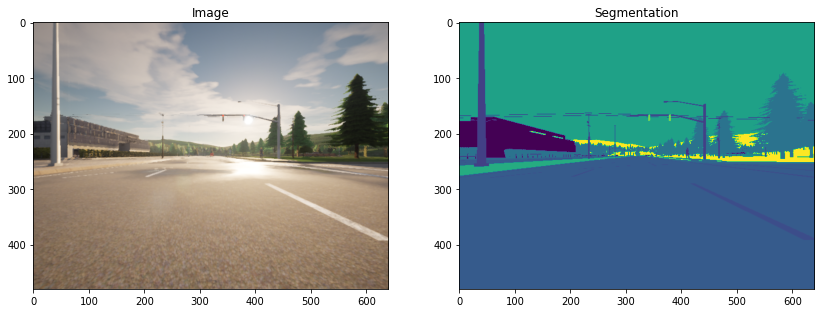

In [6]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')
plt.show()

<a name='2-2'></a>
### 2.2 - Preprocess Your Data



In [7]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        self.ImagesDirectory = ImagesDirectory
        self.MasksDirectory = MasksDirectory
        self.images = os.listdir(self.ImagesDirectory)
        self.masks = os.listdir(self.MasksDirectory)
        self.mask_transforms = transforms.Compose([
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST)
        ])
        self.image_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[0:3])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]

        img_path = os.path.join(self.ImagesDirectory, img_name)
        img = io.read_file(img_path)
        img = io.decode_png(img)
        
        mask_path = os.path.join(self.MasksDirectory, img_name)
        mask = io.read_image(mask_path)
        mask, _ = torch.max(mask[0:3], dim=0, keepdim=True)
        img, mask = self.image_transforms(img), self.mask_transforms(mask)
        return {"IMAGE": img , "MASK": mask}

<a name='2-3'></a>
### 2.3 - Hyper-parameters and Optimizer

In [8]:
# TO DO
EPOCHS = 30
BATCH_SIZE = 8 
LR = 0.001
B1 = 0.9
B2 = 0.999

<a name='3'></a>
## 3 - U-Net 

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 

<a name='3-1'></a>
### 3.1 - Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 valid padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.

#### Important Note: 
The figures shown in the assignment for the U-Net architecture depict the layer dimensions and filter sizes as per the original paper on U-Net with smaller images. However, due to computational constraints for this assignment, you will code only half of those filters. The purpose of showing you the original dimensions is to give you the flavour of the original U-Net architecture. The important takeaway is that you multiply by 2 the number of filters used in the previous step. The notebook includes all of the necessary instructions and hints to help you code the U-Net architecture needed for this assignment.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

In [9]:
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=32, dropout_prob=0, max_pooling=True):
        """
        Convolutional downsampling block

        Arguments:
            in_ch -- Number of channels of input tensor
            n_filters -- Number of filters for the convolutional layers
            dropout_prob -- Dropout probability
            max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        Returns: 
            next_layer, skip_connection --  Next layer and skip connection outputs
        """
        self.dropout = dropout_prob > 0
        self.max_pooling = max_pooling
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, n_filters, kernel_size=3, padding = 1)
        self.bn1 = nn.BatchNorm2d(n_filters)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding = 1)
        self.bn2 = nn.BatchNorm2d(n_filters)
        self.relu2 = nn.ReLU(inplace=True)
        
        if self.dropout:
            self.dropout_layer = nn.Dropout2d(p=dropout_prob)
        
        if self.max_pooling:
            self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        skip_connection = self.conv1(x)
        skip_connection = self.bn1(skip_connection)
        skip_connection = self.relu1(skip_connection)

        if self.dropout:
          skip_connection = self.dropout_layer(skip_connection)
        
        skip_connection = self.conv2(skip_connection)
        skip_connection = self.bn2(skip_connection)
        skip_connection = self.relu2(skip_connection)
        
        if self.dropout:
            skip_connection = self.dropout_layer(skip_connection)

        next_layer = skip_connection if not self.max_pooling else self.pooling_layer(skip_connection)
        
        return next_layer, skip_connection


In [10]:
unet = conv_block(in_ch = 3).to(device)
summary(unet, (3, 192, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 192, 256]        896
├─BatchNorm2d: 1-2                       [-1, 32, 192, 256]        64
├─ReLU: 1-3                              [-1, 32, 192, 256]        --
├─Conv2d: 1-4                            [-1, 32, 192, 256]        9,248
├─BatchNorm2d: 1-5                       [-1, 32, 192, 256]        64
├─ReLU: 1-6                              [-1, 32, 192, 256]        --
├─MaxPool2d: 1-7                         [-1, 32, 96, 128]         --
Total params: 10,272
Trainable params: 10,272
Non-trainable params: 0
Total mult-adds (M): 495.45
Input size (MB): 0.56
Forward/backward pass size (MB): 48.00
Params size (MB): 0.04
Estimated Total Size (MB): 48.60


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 192, 256]        896
├─BatchNorm2d: 1-2                       [-1, 32, 192, 256]        64
├─ReLU: 1-3                              [-1, 32, 192, 256]        --
├─Conv2d: 1-4                            [-1, 32, 192, 256]        9,248
├─BatchNorm2d: 1-5                       [-1, 32, 192, 256]        64
├─ReLU: 1-6                              [-1, 32, 192, 256]        --
├─MaxPool2d: 1-7                         [-1, 32, 96, 128]         --
Total params: 10,272
Trainable params: 10,272
Non-trainable params: 0
Total mult-adds (M): 495.45
Input size (MB): 0.56
Forward/backward pass size (MB): 48.00
Params size (MB): 0.04
Estimated Total Size (MB): 48.60

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `cat`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

Here you'll encounter the `ConvTranspose2d` layer, which performs the inverse of the `Conv2d` layer.



In [11]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32):
        """
        Convolutional upsampling block
        
        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            skip_ch -- Number of channels of input tensor from previous skip layer
            n_filters -- Number of filters for the convolutional layers
        Returns: 
            conv -- Tensor output
        """
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_ch, skip_ch, kernel_size=3, padding = 1)
        self.bn1 = nn.BatchNorm2d(skip_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(skip_ch, skip_ch, kernel_size=3, padding = 1)
        self.bn2 = nn.BatchNorm2d(skip_ch)
        self.relu2 = nn.ReLU(inplace=True)
    
    def forward(self, expansive_input, contractive_input):
        x = self.upconv(expansive_input)
        x = torch.cat([x, contractive_input], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. That's because there are 23 possible labels for each pixel in this self-driving car dataset. 

In [12]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=32, n_classes=23):
        super().__init__()
        # Down-sampling
        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.conv_block1 = conv_block(3, n_filters = 32, dropout_prob=0.2, max_pooling = True)
        self.conv_block2 = conv_block(32, n_filters = 64, dropout_prob=0.2, max_pooling = True)
        self.conv_block3 = conv_block(64, n_filters = 128, dropout_prob = 0.2, max_pooling = True)
        self.conv_block4 = conv_block(128, 256, dropout_prob = 0.2, max_pooling = True)
        self.conv_block5 = conv_block(256, 512, dropout_prob = 0.2, max_pooling = False)
        ######################################################
        ######################################################
        ######################################################


        # Up-sampling
        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.up_block1 = upsampling_block(512, 256)
        self.up_block2 = upsampling_block(256, 128)
        self.up_block3 = upsampling_block(128, 64)
        self.up_block4 = upsampling_block(64, 32)
        ######################################################
        ######################################################
        ######################################################

        self.last = nn.Conv2d(32, 23, kernel_size = 1)

    def forward(self, x):
      
        ######################################################
        ###################### TO DO #########################
        ######################################################
        next, skip1 = self.conv_block1(x)
        next, skip2 = self.conv_block2(next)
        next, skip3 = self.conv_block3(next)
        next, skip4 = self.conv_block4(next)
        next, _ = self.conv_block5(next)
        next = self.up_block1(next, skip4)
        next = self.up_block2(next, skip3)
        next = self.up_block3(next, skip2)
        next = self.up_block4(next, skip1)
        next = self.last(next)
        ######################################################
        ######################################################
        ######################################################

        return next


### Check out the model summary below! 

In [13]:
unet = UNet().to(device)
summary(unet, (3, 192, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─conv_block: 1-1                        [-1, 32, 96, 128]         --
|    └─Conv2d: 2-1                       [-1, 32, 192, 256]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 192, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 192, 256]        --
|    └─Dropout2d: 2-4                    [-1, 32, 192, 256]        --
|    └─Conv2d: 2-5                       [-1, 32, 192, 256]        9,248
|    └─BatchNorm2d: 2-6                  [-1, 32, 192, 256]        64
|    └─ReLU: 2-7                         [-1, 32, 192, 256]        --
|    └─Dropout2d: 2-8                    [-1, 32, 192, 256]        --
|    └─MaxPool2d: 2-9                    [-1, 32, 96, 128]         --
├─conv_block: 1-2                        [-1, 64, 48, 64]          --
|    └─Conv2d: 2-10                      [-1, 64, 96, 128]         18,496
|    └─BatchNorm2d: 2-11                 [-1, 64, 96, 128]         128
|    └

Layer (type:depth-idx)                   Output Shape              Param #
├─conv_block: 1-1                        [-1, 32, 96, 128]         --
|    └─Conv2d: 2-1                       [-1, 32, 192, 256]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 192, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 192, 256]        --
|    └─Dropout2d: 2-4                    [-1, 32, 192, 256]        --
|    └─Conv2d: 2-5                       [-1, 32, 192, 256]        9,248
|    └─BatchNorm2d: 2-6                  [-1, 32, 192, 256]        64
|    └─ReLU: 2-7                         [-1, 32, 192, 256]        --
|    └─Dropout2d: 2-8                    [-1, 32, 192, 256]        --
|    └─MaxPool2d: 2-9                    [-1, 32, 96, 128]         --
├─conv_block: 1-2                        [-1, 64, 48, 64]          --
|    └─Conv2d: 2-10                      [-1, 64, 96, 128]         18,496
|    └─BatchNorm2d: 2-11                 [-1, 64, 96, 128]         128
|    └

<a name='3-6'></a>
### 3.6 - Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [14]:
dataloader = DataLoader(Segmentation_Dataset(image_path, mask_path), batch_size=BATCH_SIZE, shuffle=True)

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].permute(1, 2, 0))
        plt.axis('off')
    return plt

torch.Size([8, 3, 192, 256])


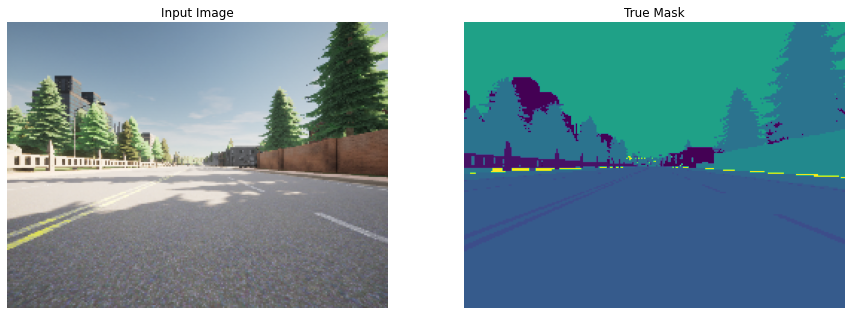

In [16]:
######################################################
###################### TO DO #########################
######################################################
for batch_idx, batch in enumerate(dataloader):
  image, mask = batch['IMAGE'], batch['MASK']
  print(image.shape)
  display_list = [image[0], mask[0]]
  display(display_list)
  break
######################################################
######################################################
######################################################

<a name='3-7'></a>
### 3.7 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2))

<a name='4'></a>
## 4 - Train the Model

In [19]:
losses = []
for epoch in range(EPOCHS):
    epoch_losses = []
    running_loss = 0
    for i, batch in enumerate(dataloader):

        ######################################################
        ###################### TO DO #########################
        ######################################################
        # Complete the train loop                            #
        # Hint: You might need to reshape MASK prior to      #
        #       calculating the loss using the code below:   #
        #       N, C, H, W = MASK.shape                      #
        #       MASK = MASK.reshape((N, H, W)).long()        #
        ######################################################
        ######################################################
        ######################################################
        optimizer.zero_grad()
        image, mask = batch['IMAGE'].to(device), batch['MASK'].squeeze(1).to(device).long()
        pred = unet(image)
        loss = criterion(pred, mask)
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        print(f'EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}')
    losses.append(np.mean(epoch_losses))

EPOCH#0,	 Batch#0,	 Loss:3.263526201248169
EPOCH#0,	 Batch#1,	 Loss:3.0247347354888916
EPOCH#0,	 Batch#2,	 Loss:2.8274242877960205
EPOCH#0,	 Batch#3,	 Loss:2.7290194034576416
EPOCH#0,	 Batch#4,	 Loss:2.651216506958008
EPOCH#0,	 Batch#5,	 Loss:2.5154073238372803
EPOCH#0,	 Batch#6,	 Loss:2.378551721572876
EPOCH#0,	 Batch#7,	 Loss:2.295391082763672
EPOCH#0,	 Batch#8,	 Loss:2.305109739303589
EPOCH#0,	 Batch#9,	 Loss:2.1895968914031982
EPOCH#0,	 Batch#10,	 Loss:2.165663003921509
EPOCH#0,	 Batch#11,	 Loss:2.12237811088562
EPOCH#0,	 Batch#12,	 Loss:2.063822031021118
EPOCH#0,	 Batch#13,	 Loss:2.051576852798462
EPOCH#0,	 Batch#14,	 Loss:1.9161759614944458
EPOCH#0,	 Batch#15,	 Loss:1.9400571584701538
EPOCH#0,	 Batch#16,	 Loss:1.9228869676589966
EPOCH#0,	 Batch#17,	 Loss:1.8995589017868042
EPOCH#0,	 Batch#18,	 Loss:1.8490486145019531
EPOCH#0,	 Batch#19,	 Loss:1.8488359451293945
EPOCH#0,	 Batch#20,	 Loss:1.7943381071090698
EPOCH#0,	 Batch#21,	 Loss:1.6805158853530884
EPOCH#0,	 Batch#22,	 Loss:1.70

<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

Now, define a function that uses `torch.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [20]:
def create_mask(pred_mask):
    ######################################################
    ###################### TO DO #########################
    ######################################################
    pred_mask = torch.argmax(pred_mask, axis=1)
    ######################################################
    ######################################################
    ######################################################
  
    return pred_mask

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did! 

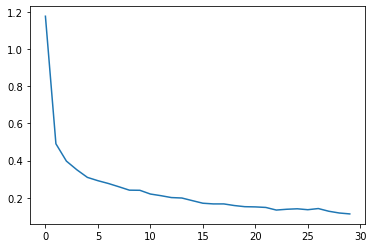

In [21]:
plt.plot(np.arange(len(losses)), losses)

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [22]:
def show_predictions(dataloader, device, num=1):
    """
    Displays the first image of each of the num batches
    """
    for i, batch in enumerate(dataloader):
        IMG = batch["IMAGE"].to(device)
        MASK = batch["MASK"].to(device)

        pred_mask = unet(IMG)
        pred_mask = create_mask(pred_mask)[0]

        pred_mask = pred_mask.unsqueeze(0)
        display([IMG[0].cpu(), MASK[0].cpu(), pred_mask.cpu()]).show()

        if i >= num:
            break

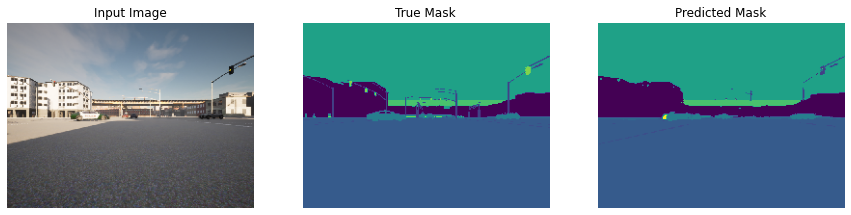

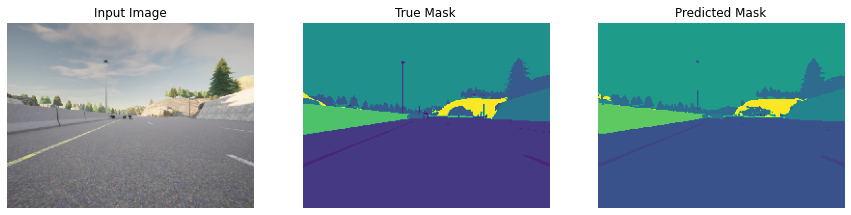

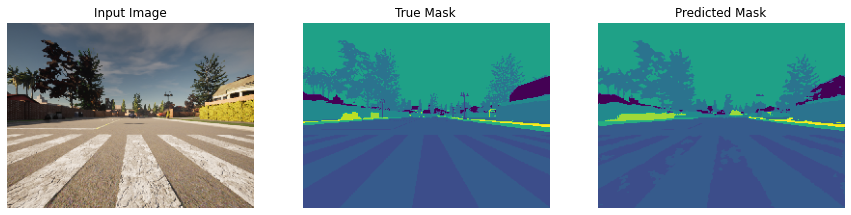

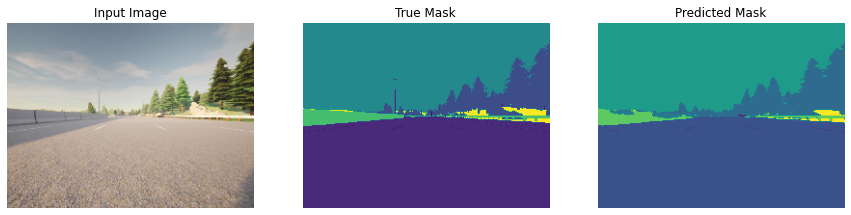

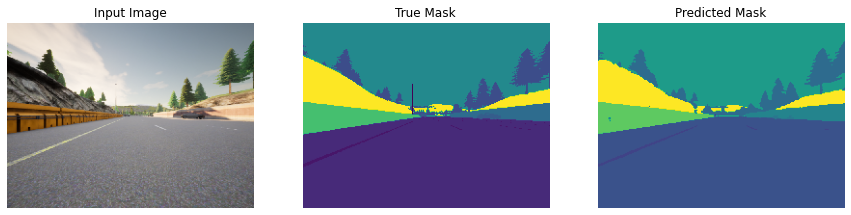

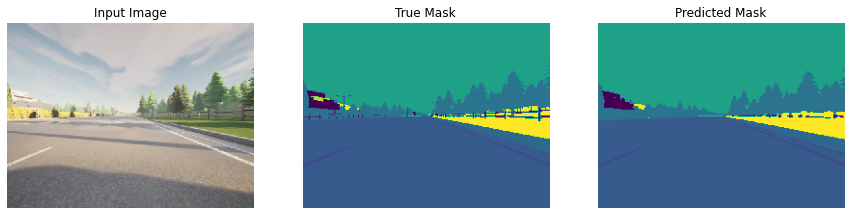

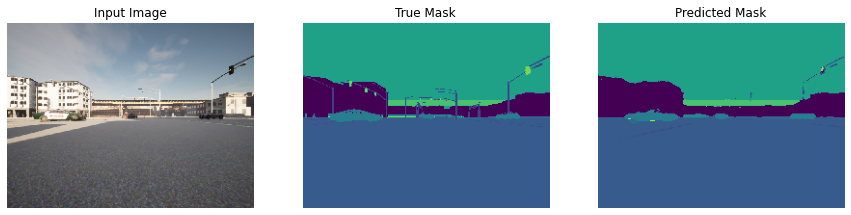

In [23]:
show_predictions(dataloader, device, 6)

<a name='5'></a>
## 5 - Conclusion 

You've come to the end of this assignment. Awesome work creating a state-of-the art model for semantic image segmentation! This is a very important task for self-driving cars to get right. Elon Musk will surely be knocking down your door at any moment. ;) 

<font color='blue'>
    
**What you should remember**: 

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net